In [98]:
# importing requried libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

## Some Helper functions

In [114]:
def plotData(X, y):
    fig = plt.figure()
    plt.plot(X[y==1, 0], X[y==1, 1], 'k*', lw=2, ms=10)
    plt.plot(X[y==0,0], X[y==0, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
    plt.show()

In [99]:
def mapFeature(X1, X2, degree=6):
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out, dtype="object")

In [100]:
def plot_boundary(params, X,Y):
    theta = params
    y = Y.copy()

    if X.shape[1] <= 3: 

        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        fig = plt.figure()
        plt.plot(X[:, 1:3][y==1, 0], X[:, 1:3][y==1, 1], 'k*', lw=2, ms=10)
        plt.plot(X[:, 1:3][y==0,0], X[:, 1:3][y==0, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
        plt.plot(plot_x, plot_y)

        plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
        plt.xlim([30, 100])
        plt.ylim([30, 100])

    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  
        fig = plt.figure()
        plt.plot(X[:, 1:3][y==1, 0], X[:, 1:3][y==1, 1], 'k*', lw=2, ms=10)
        plt.plot(X[:, 1:3][y==0,0], X[:, 1:3][y==0, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
        plt.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)

    plt.show

## LogisticRegression class

In [102]:
class LogisticRegression:
    def __init__(self) -> None:
        self.X = None
        self.Y = None
        self.parameters = None
        self.cost_history = []
        self.mu = None
        self.sigma = None
    
    def sigmoid(self, x):
        z = np.array(x)
    
        g = np.zeros(z.shape)

        g = 1/(1 + np.exp(-z) ) 

        return g

    def calculate_cost(self):
        """
        Returns the cost and gradients.
        parameters: None
        
        Returns:
            cost : Caculated loss (scalar).
            gradients: array containing the gradients w.r.t each parameter

        """

        m = self.X.shape[0]

        z = np.dot(self.X, self.parameters)
        z = z.reshape(-1)
        z = z.astype(np.float128, copy=False)
        y_hat = self.sigmoid(z)
        cost = -1 * np.mean(self.Y*(np.log(y_hat)) + (1-self.Y)*(np.log(1-y_hat)))

        gradients = np.zeros(self.X.shape[1])

        for n in range(len(self.parameters)):
            temp = np.mean((y_hat-self.Y)*self.X[:,n])
            gradients[n] = temp

        # Vectorized form
        #  gradients = np.dot(self.X.T, error)/m 

        return cost, gradients


    def init_parameters(self):
        """
        Initialize the parameters as array of 0s
        parameters: None
        
        Returns:None

        """
        self.parameters = np.zeros((self.X.shape[1],1))


    def feature_normalize(self, X):
        """
        Normalize the samples.
        parameters: 
            X : input/feature matrix
        
        Returns:
            X_norm : Normalized X.

        """
        X_norm = X.copy()
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)

        self.mu = mu
        self.sigma = sigma

        for n in range(X.shape[1]):
            X_norm[:,n] = (X_norm[:,n] - mu[n]) / sigma[n]
        return X_norm

    def fit(self, x, y, learning_rate=0.01, epochs=500, is_normalize=True, verbose=0):
        """
        Iterates and find the optimal parameters for input dataset
        parameters: 
            x : input/feature matrix
            y : target matrix
            learning_rate: between 0 and 1 (default is 0.01)
            epochs: number of iterations (default is 500)
            is_normalize: boolean, for normalizing features (default is True)
            verbose: iterations after to print cost
        
        Returns:
            parameters : Array of optimal value of weights.

        """
        self.X = x
        self.Y = y
        self.cost_history = []
        if self.X.ndim == 1: # adding extra dimension, if X is a 1-D array
            self.X = self.X.reshape(-1,1)
            is_normalize = False
        if is_normalize:
            self.X = self.feature_normalize(self.X)
        self.X = np.concatenate([np.ones((self.X.shape[0],1)), self.X], axis=1)
        print(self.X.shape)
        self.init_parameters()

        for i in range(epochs):
            cost, gradients = self.calculate_cost()
            self.cost_history.append(cost)
            self.parameters -= learning_rate * gradients.reshape(-1,1)

            if verbose:
                if not (i % verbose):
                    print(f"Cost after {i} epochs: {cost}")
        return self.parameters


    def predict(self,x, is_normalize=True):
        """
        Returns the predictions after fitting.
        parameters: 
            x : input/feature matrix
        
        Returns:
            predictions : Array of predicted target values.

        """
        x = np.array(x, dtype=np.float64) # converting list to numpy array
        if x.ndim == 1:
            x = x.reshape(1,-1)
        if is_normalize:
            for n in range(x.shape[1]):
                x[:,n] = (x[:,n] - self.mu[n]) / self.sigma[n]
        x = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)
        return [1 if i > 0.5 else 0  for i in self.sigmoid(np.dot(x,self.parameters))]

### On dataset 1

In [103]:
data1 = np.loadtxt("./data/data1.txt", delimiter=",")

In [104]:
model = LogisticRegression()

In [105]:
X = data1[:,:2]
Y = data1[:,2]
print(X.shape, Y.shape)

(100, 2) (100,)


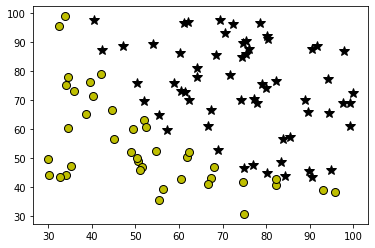

In [115]:
plotData(X,Y)

In [107]:
epoch = 10000
params = model.fit(X,Y, epochs=epoch, is_normalize=True)
params

(100, 3)


array([[1.27071379],
       [3.04735849],
       [2.81165934]])

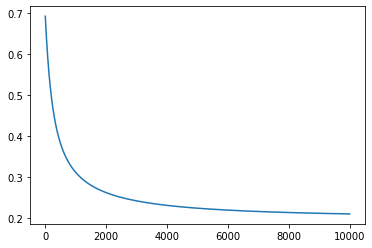

In [108]:
plt.plot(np.array(list(range(epoch))), model.cost_history)

In [111]:
preds = model.predict(X, is_normalize=True)
accuracy = sum(preds == Y)/len(Y)
print(f"Accuracy in percent: {accuracy*100}%")

Accuracy in percent: 89.0%


### Dataset 2

In [144]:
data2 = np.loadtxt("./data/data2.txt", delimiter=",")
data2.shape

(118, 3)

In [145]:
X2 = data2[:,:2]
Y2 = data2[:,2]
print(X2.shape, Y2.shape)

(118, 2) (118,)


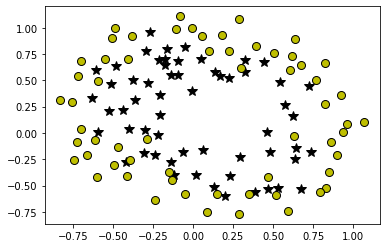

In [146]:
plotData(X2,Y2)

In [147]:
model2 = LogisticRegression()

In [148]:
X2 = mapFeature(X2[:,0], X2[:,1])
X2.shape

(118, 28)

In [149]:
epoch = 10000
params2 = model2.fit(X2[:,1:], Y2, epochs=epoch, is_normalize=False, verbose=1000)

(118, 28)
Cost after 0 epochs: 0.6931471805599453
Cost after 1000 epochs: 0.6237359297188391
Cost after 2000 epochs: 0.5838711002603695
Cost after 3000 epochs: 0.5542293019415869
Cost after 4000 epochs: 0.5307294813687752
Cost after 5000 epochs: 0.5115159728458224
Cost after 6000 epochs: 0.49548412384095797
Cost after 7000 epochs: 0.4818937659707769
Cost after 8000 epochs: 0.4702214356266024
Cost after 9000 epochs: 0.46008487886422844


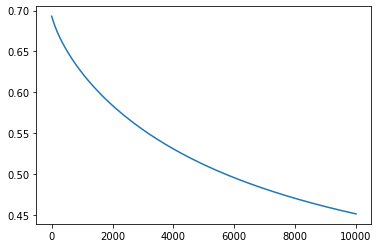

In [150]:
plt.plot(np.array(list(range(epoch))), model2.cost_history)

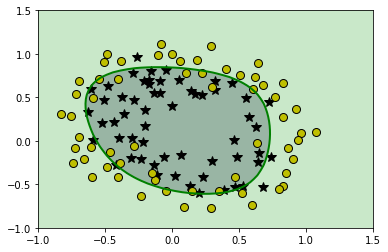

In [151]:
plot_boundary(params2,X2,Y2)

In [152]:
preds2 = model2.predict(X2[:,1:],is_normalize=False)
accuracy2 = sum(preds2 == Y2)/len(Y2)
print(f"Accuracy in percent: {accuracy2*100}%")

Accuracy in percent: 83.05084745762711%


## Regularized Logistic Regression

In [63]:
class RegLogisticRegression:
    def __init__(self) -> None:
        self.X = None
        self.Y = None
        self.parameters = None
        self.cost_history = []
        self.mu = None
        self.sigma = None
    
    def sigmoid(self, x):
        z = np.array(x)
    
        g = np.zeros(z.shape)

        g = 1/(1 + np.exp(-z) ) 

        return g

    def sigmoid_derivative(self, x):
        derivative = self.sigmoid(x) * (1 - self.sigmoid(x))
        return derivative

    def calculate_cost(self, lambda_):
        """
        Returns the cost and gradients.
        parameters: None
        
        Returns:
            cost : Caculated loss (scalar).
            gradients: array containing the gradients w.r.t each parameter

        """

        m = self.X.shape[0]

        z = np.dot(self.X, self.parameters)
        z = z.reshape(-1)
        z = z.astype(np.float128, copy=False)
        y_hat = self.sigmoid(z)
        cost = -1 * np.mean(self.Y*(np.log(y_hat)) + (1-self.Y)*(np.log(1-y_hat))) + lambda_ * (np.sum(self.parameters[1:]**2))/(2*m)

        gradients = np.zeros(self.X.shape[1])

        for n in range(len(self.parameters)):
            if n == 0:
                temp = np.mean((y_hat-self.Y)*self.X[:,n])
            else:
                temp = np.mean((y_hat-self.Y)*self.X[:,n]) + lambda_*self.parameters[n]/m
            gradients[n] = temp

        # gradients = np.dot(self.X.T, error)/m

        return cost, gradients


    def init_parameters(self):
        """
        Initialize the parameters as array of 0s
        parameters: None
        
        Returns:None

        """
        self.parameters = np.zeros((self.X.shape[1],1))


    def feature_normalize(self, X):
        """
        Normalize the samples.
        parameters: 
            X : input/feature matrix
        
        Returns:
            X_norm : Normalized X.

        """
        X_norm = X.copy()
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)

        self.mu = mu
        self.sigma = sigma

        for n in range(X.shape[1]):
            X_norm[:,n] = (X_norm[:,n] - mu[n]) / sigma[n]
        return X_norm

    def fit(self, x, y, learning_rate=0.01, epochs=500, lambda_=0,is_normalize=True, verbose=0):
        """
        Iterates and find the optimal parameters for input dataset
        parameters: 
            x : input/feature matrix
            y : target matrix
            learning_rate: between 0 and 1 (default is 0.01)
            epochs: number of iterations (default is 500)
            is_normalize: boolean, for normalizing features (default is True)
            verbose: iterations after to print cost
        
        Returns:
            parameters : Array of optimal value of weights.

        """
        self.X = x
        self.Y = y
        self.cost_history = []
        if self.X.ndim == 1: # adding extra dimension, if X is a 1-D array
            self.X = self.X.reshape(-1,1)
            is_normalize = False
        if is_normalize:
            self.X = self.feature_normalize(self.X)
        self.X = np.concatenate([np.ones((self.X.shape[0],1)), self.X], axis=1)
        print(self.X.shape)
        self.init_parameters()

        for i in range(epochs):
            cost, gradients = self.calculate_cost(lambda_=lambda_)
            self.cost_history.append(cost)
            self.parameters -= learning_rate * gradients.reshape(-1,1)

            if verbose:
                if not (i % verbose):
                    print(f"Cost after {i} epochs: {cost}")
        return self.parameters


    def predict(self,x, is_normalize=True):
        """
        Returns the predictions after fitting.
        parameters: 
            x : input/feature matrix
        
        Returns:
            predictions : Array of predicted target values.

        """
        x = np.array(x, dtype=np.float64) # converting list to numpy array
        if x.ndim == 1:
            x = x.reshape(1,-1)
        if is_normalize:
            for n in range(x.shape[1]):
                x[:,n] = (x[:,n] - self.mu[n]) / self.sigma[n]
        x = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)
        return [1 if i > 0.5 else 0  for i in self.sigmoid(np.dot(x,self.parameters))]

(118, 28)
for lambda: 0 :-


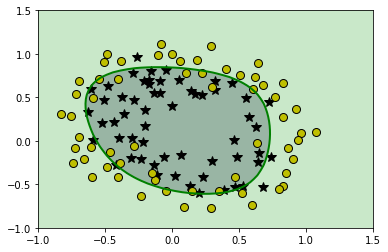

(118, 28)
for lambda: 1 :-


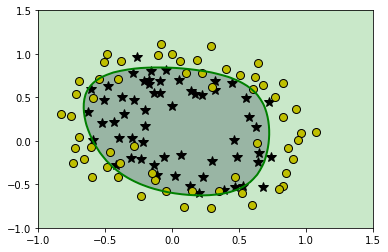

(118, 28)
for lambda: 10 :-


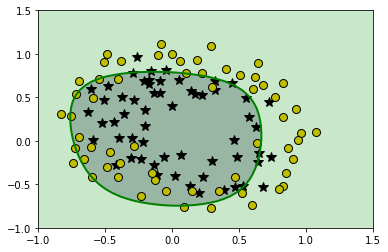

(118, 28)
for lambda: 100 :-


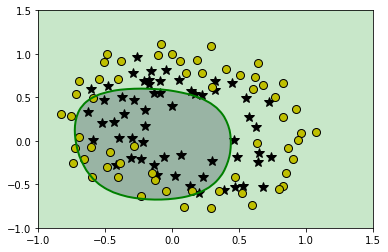

In [154]:
lambdas = [0,1,10,100]
epoch = 10000
cost_hist = {}
for lambda_ in lambdas:
    model3 = RegLogisticRegression()
    param = model3.fit(X2[:,1:],Y2,epochs=epoch, lambda_=lambda_,is_normalize=False)
    cost_hist[lambda_] = model3.cost_history
    plot_boundary(param,X2,Y2)
    print(f"for lambda: {lambda_} :-")
    plt.show()

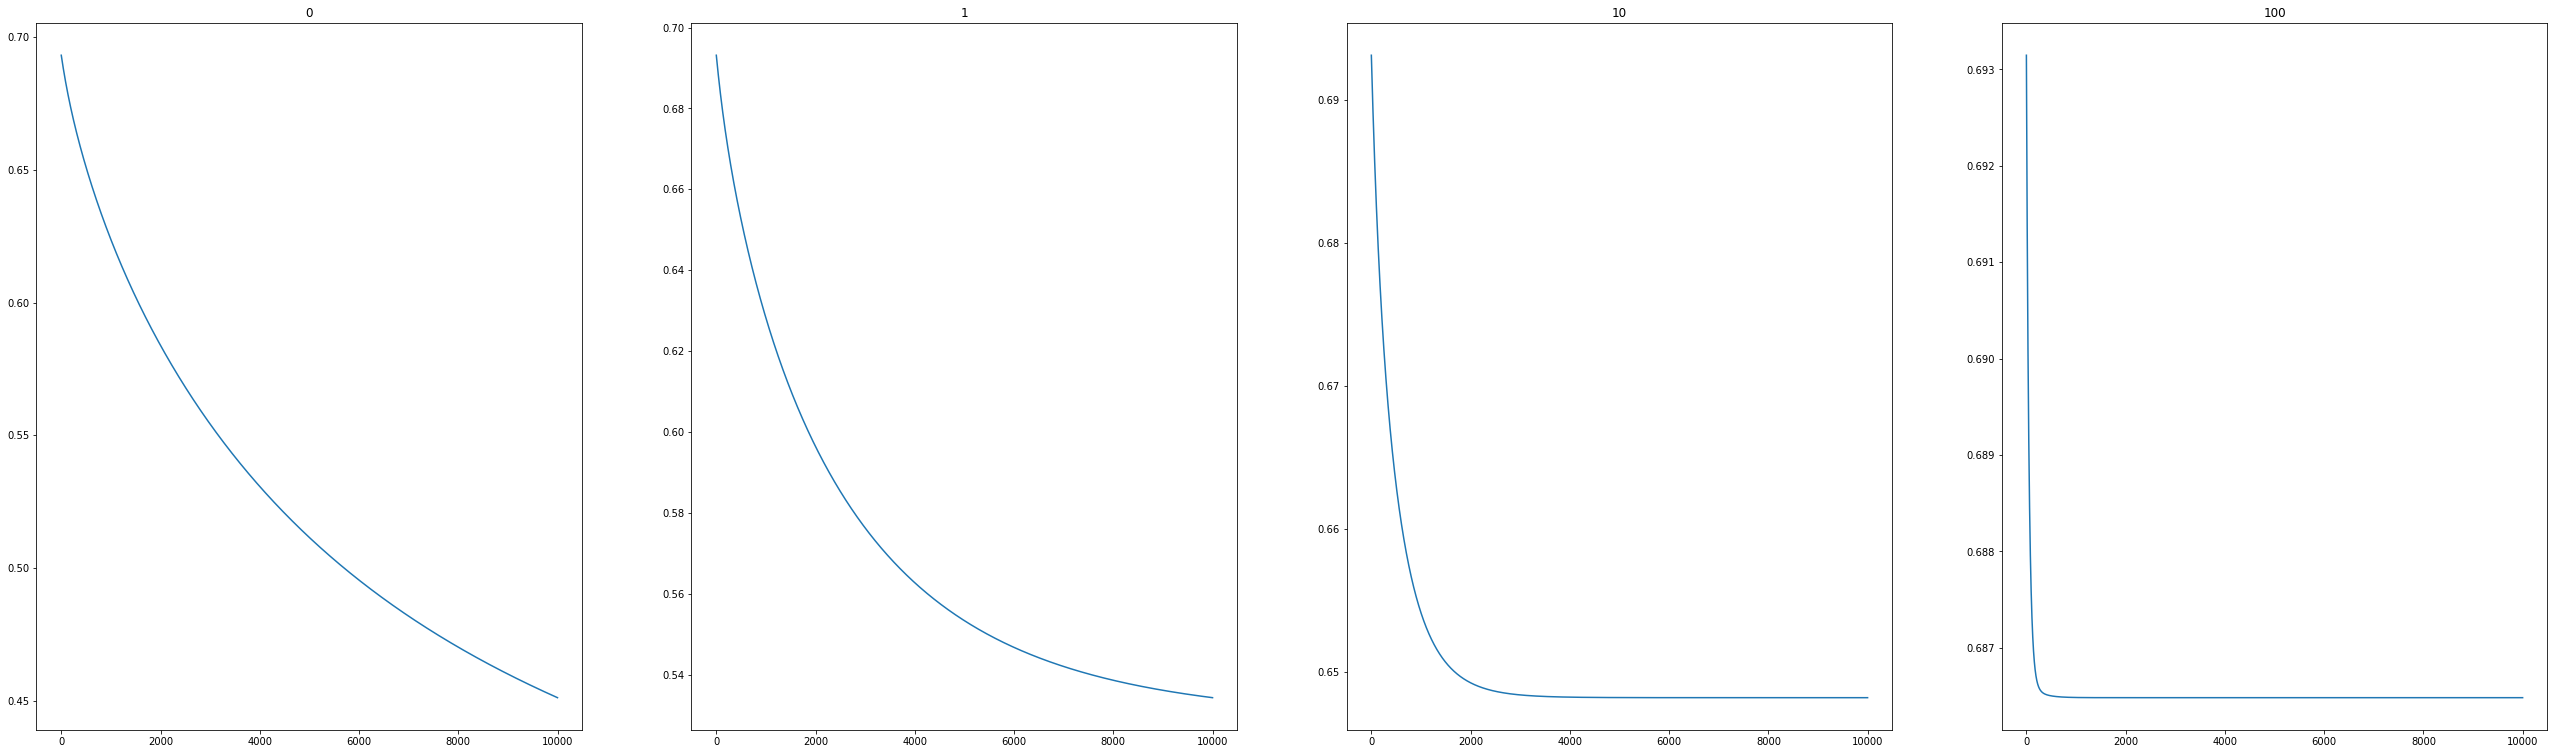

In [163]:
fig, ax = plt.subplots(1,len(lambdas), figsize=(45,13))
for i,value in enumerate(cost_hist.items()):
    lambda_, cost = value
    ax[i].set_title(lambda_)
    ax[i].plot(list(range(epoch)), cost)

## Using `scipy.optimize.minimize` for faster calculation of parameters

In [164]:
def sigmoid(z):
    z = np.array(z)
    g = np.zeros(z.shape)
    g = 1/(1 + np.exp(-z))    
    return g

In [165]:
def costFunction(theta, X, y):
    m = y.size  # number of training examples
    J = 0
    grad = np.zeros(theta.shape)
    z = theta.dot(X.T)
    h_x = sigmoid(z) # calculating hypothesis (h(x))
    J = -1 * np.mean(y*(np.log(h_x)) + (1-y)*(np.log(1-h_x)))

    for n in range(len(theta)):
        temp = np.mean((h_x-y)*X[:,n])
        grad[n] = temp
    
    return J, grad

In [167]:

options= {'maxiter': 400}
initial_theta = np.zeros(X.shape[1])
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X2, Y2),
                        jac=True,
                        method='TNC',
                        options=options)

cost = res.fun

theta = res.x

print('theta:')
print(theta)

theta:
[  10.92027345   14.41391834    7.88894898 -110.40678327  -60.42008079
  -37.95687737 -114.01965814 -111.99006425  -53.43041923   -1.52249018
  394.07166451  365.76145912  440.85613847  196.55506339   39.68952515
  206.07889741  326.45600885  367.58929579  219.80400101   66.69281066
   -3.45105098 -468.76307498 -640.56432545 -905.67014421 -687.59858489
 -602.68613342 -237.83544253  -23.43941239]
